In [1]:
import gym
import gym_inventory
import matplotlib as mpl
import matplotlib

import os
import datetime
import numpy as np
import cloudpickle
import gym
from gym import error, spaces
from gym.utils import seeding
import itertools
from collections import deque
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

%matplotlib inline
from tqdm import tqdm

In [2]:
env = gym.make('JSinventory-v0')

In [3]:
# namedtuple 생성
from collections import namedtuple, OrderedDict

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
# transition을 저장하기 위한 메모리 클래스


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # 메모리의 최대 저장 건수
        self.memory = []  # 실제 transition을 저장할 변수
        self.index = 0  # 저장 위치를 가리킬 인덱스 변수

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)을 메모리에 저장'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # 메모리가 가득차지 않은 경우

        # Transition이라는 namedtuple을 사용하여 키-값 쌍의 형태로 값을 저장
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 다음 저장할 위치를 한 자리 뒤로 수정

    def sample(self, batch_size):
        '''batch_size 갯수 만큼 무작위로 저장된 transition을 추출'''
        return random.sample(self.memory[:], batch_size)

    def __len__(self):
        '''len 함수로 현재 저장된 transition 갯수를 반환'''
        return len(self.memory)

In [5]:
# Dueling Network 신경망 구성
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_mid)
        # Dueling Network
        self.fc4_adv = nn.Linear(n_mid, n_out)  # Advantage함수쪽 신경망
        self.fc4_v = nn.Linear(n_mid, 1)  # 가치 V쪽 신경망

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))

        adv = self.fc4_adv(h3)  # 이 출력은 ReLU를 거치지 않음
        val = self.fc4_v(h3).expand(-1, adv.size(1))  # 이 출력은 ReLU를 거치지 않음
        # val은 adv와 덧셈을 하기 위해 expand 메서드로 크기를 [minibatch*1]에서 [minibatch*2]로 변환
        # adv.size(1)은 2(출력할 행동의 가짓수)

        output = val + adv - adv.mean(1, keepdim=True).expand(-1, adv.size(1))
        # val+adv에서 adv의 평균을 뺀다
        # adv.mean(1, keepdim=True) 으로 열방향(행동의 종류 방향) 평균을 구함 크기는 [minibatch*1]이 됨
        # expand 메서드로 크기를 [minibatch*2]로 늘림
        return output

In [6]:
# 에이전트의 두뇌 역할을 하는 클래스, DDQN을 실제 수행한다 

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 64
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions 

        # transition을 기억하기 위한 메모리 객체 생성
        self.memory = ReplayMemory(CAPACITY)

        # 신경망 구성
        n_in, n_mid, n_out = num_states, 32, num_actions
        self.main_q_network = Net(n_in, n_mid, n_out)  # Net 클래스를 사용
        self.target_q_network = Net(n_in, n_mid, n_out)  # Net 클래스를 사용
#         print(self.main_q_network)  # 신경망의 구조를 출력

        # 최적화 기법 선택
        self.optimizer = optim.Adam(
            self.main_q_network.parameters(), lr=0.0005)

    def replay(self):
        '''Experience Replay로 신경망의 결합 가중치 학습'''

        # 1. 저장된 transition의 수를 확인
        if len(self.memory) < 2*BATCH_SIZE:
            return

        # 2. 미니배치 생성
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()        
        
        # 3. 정답신호로 사용할 Q(s_t, a_t)를 계산
        self.expected_state_action_values = self.get_expected_state_action_values()

        # 4. 결합 가중치 수정
        self.update_main_q_network()

    def decide_action(self, state, episode, istest):
        '''현재 상태로부터 행동을 결정함'''
        # ε-greedy 알고리즘에서 서서히 최적행동의 비중을 늘린다
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1) or istest == True:
            self.main_q_network.eval()  # 신경망을 추론 모드로 전환
            with torch.no_grad():
                action = self.main_q_network(state).max(1)[1].view(1, 1)
            # 신경망 출력의 최댓값에 대한 인덱스 = max(1)[1]
            # .view(1,1)은 [torch.LongTensor of size 1] 을 size 1*1로 변환하는 역할을 한다

        else:
            # 행동을 무작위로 반환(0 혹은 1)
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 행동을 무작위로 반환
            # action은 [torch.LongTensor of size 1*1] 형태가 된다 

        return action

    def make_minibatch(self):
        '''2. 미니배치 생성'''

        # 2.1 메모리 객체에서 미니배치를 추출
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 각 변수를 미니배치에 맞는 형태로 변형
        # transitions는 각 단계 별로 (state, action, state_next, reward) 형태로 BATCH_SIZE 갯수만큼 저장됨
        # 다시 말해, (state, action, state_next, reward) * BATCH_SIZE 형태가 된다
        # 이것을 미니배치로 만들기 위해
        # (state*BATCH_SIZE, action*BATCH_SIZE, state_next*BATCH_SIZE, reward*BATCH_SIZE) 형태로 변환한다
        batch = Transition(*zip(*transitions))

        # 2.3 각 변수의 요소를 미니배치에 맞게 변형하고, 신경망으로 다룰 수 있도록 Variable로 만든다
        # state를 예로 들면, [torch.FloatTensor of size 1*4] 형태의 요소가 BATCH_SIZE 갯수만큼 있는 형태이다
        # 이를 torch.FloatTensor of size BATCH_SIZE*4 형태로 변형한다
        # 상태, 행동, 보상, non_final 상태로 된 미니배치를 나타내는 Variable을 생성
        # cat은 Concatenates(연접)을 의미한다

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''정답신호로 사용할 Q(s_t, a_t)를 계산'''

        # 3.1 신경망을 추론 모드로 전환
        self.main_q_network.eval()
        self.target_q_network.eval()

        # 3.2 신경망으로 Q(s_t, a_t)를 계산
        # self.model(state_batch)은 왼쪽, 오른쪽에 대한 Q값을 출력하며
        # [torch.FloatTensor of size BATCH_SIZEx2] 형태이다
        # 여기서부터는 실행한 행동 a_t에 대한 Q값을 계산하므로 action_batch에서 취한 행동 a_t가 
        # 왼쪽이냐 오른쪽이냐에 대한 인덱스를 구하고, 이에 대한 Q값을 gather 메서드로 모아온다
        
        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)
        
        
        # 3.3 max{Q(s_t+1, a)}값을 계산한다 이때 다음 상태가 존재하는지에 주의해야 한다

        # done 상태가 아니고, next_state가 존재하는지 확인하는 인덱스 마스크를 만듬
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # 먼저 전체를 0으로 초기화
        next_state_values = torch.zeros(BATCH_SIZE)

        a_m = torch.zeros(BATCH_SIZE).type(torch.LongTensor)

        # 다음 상태에서 Q값이 최대가 되는 행동 a_m을 Main Q-Network로 계산
        # 마지막에 붙은 [1]로 행동에 해당하는 인덱스를 구함
        
        
        a_m[non_final_mask] = self.main_q_network(
            self.non_final_next_states).detach().max(1)[1]
        
        # 다음 상태가 있는 것만을 걸러내고, size 32를 32*1로 변환
        a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)

        # 다음 상태가 있는 인덱스에 대해 행동 a_m의 Q값을 target Q-Network로 계산
        # detach() 메서드로 값을 꺼내옴
        # squeeze() 메서드로 size[minibatch*1]을 [minibatch]로 변환
        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).gather(1, a_m_non_final_next_states).detach().squeeze()

        
        # 3.4 정답신호로 사용할 Q(s_t, a_t)값을 Q러닝 식으로 계산한다
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values
        
        return expected_state_action_values

    def update_main_q_network(self):
        '''4. 결합 가중치 수정'''

        # 4.1 신경망을 학습 모드로 전환
        self.main_q_network.train()

        # 4.2 손실함수를 계산 (smooth_l1_loss는 Huber 함수)
        # expected_state_action_values은
        # size가 [minibatch]이므로 unsqueeze하여 [minibatch*1]로 만든다
        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # 4.3 결합 가중치를 수정한다
        self.optimizer.zero_grad()  # 경사를 초기화
        loss.backward()  # 역전파 계산
        self.optimizer.step()  # 결합 가중치 수정

    def update_target_q_network(self):  # DDQN에서 추가됨
        '''Target Q-Network을 Main Q-Network와 맞춤'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())


In [7]:
# 에이전트 클래스

class Agent:
    def __init__(self, num_states, num_actions):
        '''태스크의 상태 및 행동의 가짓수를 설정'''
        self.brain = Brain(num_states, num_actions)  # 에이전트의 행동을 결정할 두뇌 역할 객체를 생성

    def update_q_function(self):
        '''Q함수를 수정'''
        self.brain.replay()

    def get_action(self, state, episode, istest=False):
        '''행동을 결정'''
        action = self.brain.decide_action(state, episode, istest)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memory 객체에 state, action, state_next, reward 내용을 저장'''
        self.brain.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        '''Target Q-Network을 Main Q-Network와 맞춤'''
        self.brain.update_target_q_network()
        

In [8]:
print({i:int(i-(34-1)/2) for i in range(34)})

{0: -16, 1: -15, 2: -14, 3: -13, 4: -12, 5: -11, 6: -10, 7: -9, 8: -8, 9: -7, 10: -6, 11: -5, 12: -4, 13: -3, 14: -2, 15: -1, 16: 0, 17: 0, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5, 23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 11, 29: 12, 30: 13, 31: 14, 32: 15, 33: 16}


In [9]:
# 실행 환경 클래스

class Environment:

    def __init__(self):
        self.env = gym.make('JSinventory-v0')
        num_states = 6
        num_actions_0 = 34 # Factory
        num_actions_1 = 20 # Warehouse
        
        self.d_x_rule_dict_0 = {i:int(i-(num_actions_0-1)/2) for i in range(num_actions_0)}
        self.d_x_rule_dict_1 = {i:-i for i in range(num_actions_1)}

        self.agent_0 = Agent(num_states, num_actions_0)  # Manufacturer 역할을 할 객체를 생성
        self.agent_1 = Agent(num_states, num_actions_1)  # Distributor 역할을 할 객체를 생성
       
        
    def train(self):

        '''학습'''

        rewards_avg_list = []
        demand_list = []

        for episode in range(NUM_EPISODES):  # 최대 에피소드 수만큼 반복


            observation = self.env.reset()  # 환경 초기화
            rewards_list = []
            state = observation  # 관측을 변환없이 그대로 상태 s로 사용

            state = torch.tensor(state).type(torch.FloatTensor)


            for step in range(MAX_STEPS):  # 1 에피소드에 해당하는 반복문
                
                state = torch.tensor(state).type(torch.FloatTensor).reshape(-1).unsqueeze(0)

                
                action_0 = self.agent_0.get_action(state, episode, istest=False)  # 다음 행동을 결정
                action_0_ = self.d_x_rule_dict_0[action_0.item()] # d + x 를 위한 변환
                num_man = max(state.numpy()[0][5] + action_0_, 0)

                action_1 = self.agent_1.get_action(state, episode, istest=False)  # 다음 행동을 결정
                action_1_ = self.d_x_rule_dict_1[action_1.item()] # d + x 를 위한 변환
                num_dis = max(state.numpy()[0][0] + action_1_, 0)

                action = [num_man, num_dis]
    
                observation_next, reward, done, demand = self.env.step(action, episode)
                demand_list.append(demand)
                
                # 보상을 부여하고 episode의 종료 판정 및 state_next를 설정한다
                if done:
                    state_next = None  # 다음 상태가 없으므로 None으로
                    break

                else:
                    state_next = observation_next  # 관측 결과를 그대로 상태로 사용
                    state_next = torch.tensor(state_next).type(torch.FloatTensor).reshape(-1).unsqueeze(0)


                # 메모리에 경험을 저장
                self.agent_0.memorize(state, action_0, state_next, torch.tensor(reward).unsqueeze(0).type(torch.FloatTensor))
                self.agent_1.memorize(state, action_1, state_next, torch.tensor(reward).unsqueeze(0).type(torch.FloatTensor))

                # Experience Replay로 Q함수를 수정
                self.agent_0.update_q_function()
                self.agent_1.update_q_function()


                # 관측 결과를 업데이트
                state = state_next
                rewards_list.append(reward)
                
            
            total_avg_reward = np.mean(rewards_list) 
            print('EPISODE : {} | TOTAL AVG REWARD : {}'.format(episode, total_avg_reward))
            rewards_avg_list.append(total_avg_reward)


            # DDQN으로 추가된 부분 5에피소드마다 한번씩 Target Q-Network을 Main Q-Network와 맞춰줌
            if(episode % 5 == 0):
                self.agent_0.update_target_q_function()
                self.agent_1.update_target_q_function()
        
        torch.save(self.agent_0.brain.main_q_network.state_dict(), './main_q_net_00.pt')
        torch.save(self.agent_1.brain.main_q_network.state_dict(), './main_q_net_01.pt')
        
        torch.save(self.agent_0.brain.target_q_network.state_dict(), './targ_q_net_00.pt')
        torch.save(self.agent_1.brain.target_q_network.state_dict(), './targ_q_net_01.pt')

                
        return rewards_avg_list, demand_list
    
    def test(self):
        self.agent_0.brain.main_q_network.load_state_dict(torch.load('./main_q_net_00.pt'))
        self.agent_1.brain.main_q_network.load_state_dict(torch.load('./main_q_net_01.pt'))
        
        self.agent_0.brain.main_q_network.load_state_dict(torch.load('./targ_q_net_00.pt'))
        self.agent_1.brain.main_q_network.load_state_dict(torch.load('./targ_q_net_01.pt'))

        '''테스트'''
        
        episode = NUM_EPISODES
        
        rewards_list = []
        demand_list = []
        
        
        man = []
        dis = []

        man_stock = []
        war_stock = []


        observation = self.env.reset()  # 환경 초기화
        
        state = observation  # 관측을 변환없이 그대로 상태 s로 사용
        state = torch.tensor(state).type(torch.FloatTensor)


        for step in range(MAX_STEPS):  # 1 에피소드에 해당하는 반복문

            state = torch.tensor(state).type(torch.FloatTensor).reshape(-1).unsqueeze(0)


            action_0 = self.agent_0.get_action(state, episode, istest=False)  # 다음 행동을 결정
            action_0_ = self.d_x_rule_dict_0[action_0.item()] # d + x 를 위한 변환
            num_man = max(state.numpy()[0][5] + action_0_, 0)

            action_1 = self.agent_1.get_action(state, episode, istest=False)  # 다음 행동을 결정
            action_1_ = self.d_x_rule_dict_1[action_1.item()] # d + x 를 위한 변환
            num_dis = max(state.numpy()[0][0] + action_1_, 0)

            action = [num_man, num_dis]


            
            man.append(num_man)
            dis.append(num_dis)
            man_stock.append(state.numpy()[0][0])
            war_stock.append(state.numpy()[0][1])
            
            
            observation_next, reward, done, demand = self.env.step(action, 0)
            demand_list.append(demand)

            # 보상을 부여하고 episode의 종료 판정 및 state_next를 설정한다
            if done:
                state_next = None  # 다음 상태가 없으므로 None으로
                break

            else:
                state_next = observation_next  # 관측 결과를 그대로 상태로 사용
                state_next = torch.tensor(state_next).type(torch.FloatTensor).reshape(-1).unsqueeze(0)


            # 관측 결과를 업데이트
            state = state_next
            rewards_list.append(reward)
    
        
        return rewards_list, man, man_stock, dis, war_stock, demand_list
    

In [10]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [11]:
# 상수 정의
GAMMA = 0.9  # 시간할인율
MAX_STEPS = 90  # 1에피소드 당 최대 단계 수
NUM_EPISODES = 300  # 최대 에피소드 수

# 학습 
env = Environment()
rewards_avg_list, demand_list_train = env.train()


EPISODE : 0 | TOTAL AVG REWARD : -25.528089887640448
EPISODE : 1 | TOTAL AVG REWARD : -16.01123595505618
EPISODE : 2 | TOTAL AVG REWARD : -23.01123595505618
EPISODE : 3 | TOTAL AVG REWARD : -11.235955056179776
EPISODE : 4 | TOTAL AVG REWARD : -25.179775280898877
EPISODE : 5 | TOTAL AVG REWARD : -18.696629213483146
EPISODE : 6 | TOTAL AVG REWARD : -17.426966292134832
EPISODE : 7 | TOTAL AVG REWARD : -12.539325842696629
EPISODE : 8 | TOTAL AVG REWARD : -12.191011235955056
EPISODE : 9 | TOTAL AVG REWARD : -12.044943820224718
EPISODE : 10 | TOTAL AVG REWARD : -16.1123595505618
EPISODE : 11 | TOTAL AVG REWARD : -9.606741573033707
EPISODE : 12 | TOTAL AVG REWARD : -10.44943820224719
EPISODE : 13 | TOTAL AVG REWARD : -12.02247191011236
EPISODE : 14 | TOTAL AVG REWARD : -9.359550561797754
EPISODE : 15 | TOTAL AVG REWARD : -7.887640449438202
EPISODE : 16 | TOTAL AVG REWARD : -8.797752808988765
EPISODE : 17 | TOTAL AVG REWARD : -15.595505617977528
EPISODE : 18 | TOTAL AVG REWARD : -14.5280898876

EPISODE : 154 | TOTAL AVG REWARD : -5.359550561797753
EPISODE : 155 | TOTAL AVG REWARD : -5.696629213483146
EPISODE : 156 | TOTAL AVG REWARD : -4.561797752808989
EPISODE : 157 | TOTAL AVG REWARD : -5.943820224719101
EPISODE : 158 | TOTAL AVG REWARD : -4.719101123595506
EPISODE : 159 | TOTAL AVG REWARD : -6.49438202247191
EPISODE : 160 | TOTAL AVG REWARD : -6.022471910112359
EPISODE : 161 | TOTAL AVG REWARD : -8.179775280898877
EPISODE : 162 | TOTAL AVG REWARD : -4.797752808988764
EPISODE : 163 | TOTAL AVG REWARD : -4.808988764044944
EPISODE : 164 | TOTAL AVG REWARD : -4.078651685393258
EPISODE : 165 | TOTAL AVG REWARD : -4.730337078651686
EPISODE : 166 | TOTAL AVG REWARD : -5.595505617977528
EPISODE : 167 | TOTAL AVG REWARD : -7.48314606741573
EPISODE : 168 | TOTAL AVG REWARD : -6.168539325842697
EPISODE : 169 | TOTAL AVG REWARD : -6.48314606741573
EPISODE : 170 | TOTAL AVG REWARD : -5.022471910112359
EPISODE : 171 | TOTAL AVG REWARD : -5.719101123595506
EPISODE : 172 | TOTAL AVG REWAR

학습 평균 리워드:  -6.8415730337078635


Text(0.5, 1.0, '에피소드 별 리워드(Training)')

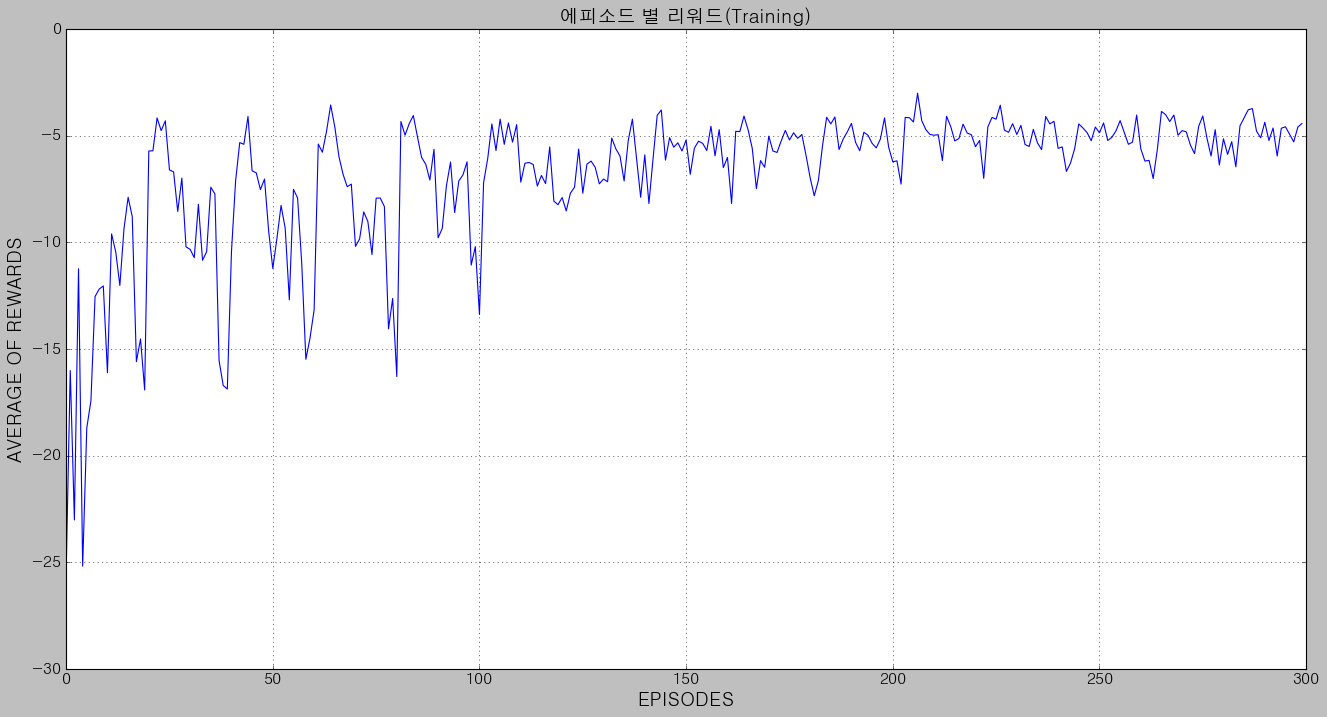

In [16]:
plt.style.use('classic')
plt.rc('font', size = 17)
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend', fontsize = 16)

print("학습 평균 리워드: ", np.mean(rewards_avg_list))

#rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

path = 'C:/Windows/Fonts/H2GTRM.TTF'
font_name = font_manager.FontProperties(fname = path).get_name()
matplotlib.rc('font', family = font_name)


figsize=(20,10)


plt.rcParams["figure.figsize"] = figsize
fig, ax = plt.subplots()
ax.plot([num for num in range(len(rewards_avg_list))], rewards_avg_list)
ax.set_xlabel('EPISODES')
ax.set_ylabel('AVERAGE OF REWARDS')
ax.grid(True)
ax.set_title('에피소드 별 리워드(Training)')


In [17]:
# 학습 
env = Environment()
rewards_list, man, man_stock, dis, war_stock, demand_list_test = env.test()

In [18]:
np.mean(rewards_list)

-3.7865168539325844

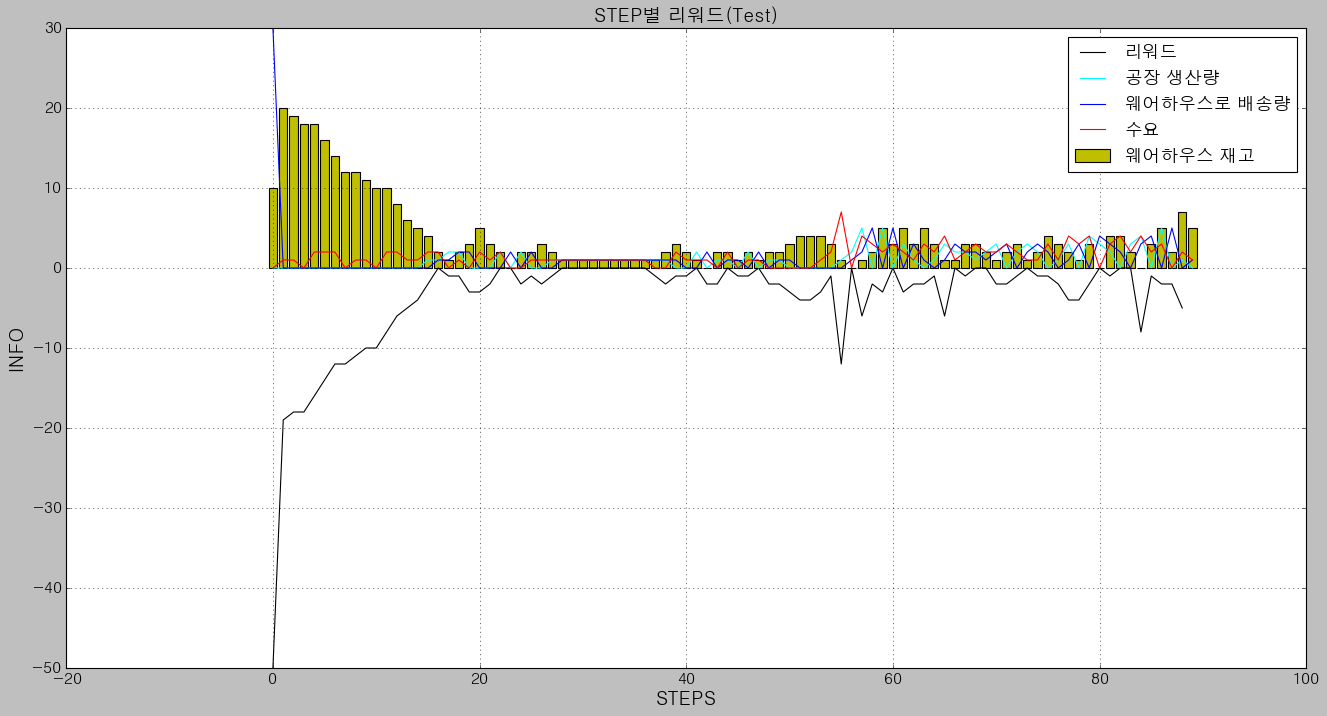

In [19]:
plt.style.use('classic')
plt.rc('font', size = 17)
plt.rc('axes', titlesize = 17)
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('legend', fontsize = 16)

path = 'C:/Windows/Fonts/H2GTRM.TTF'
font_name = font_manager.FontProperties(fname = path).get_name()
matplotlib.rc('font', family = font_name)
rc('axes', unicode_minus=False)


figsize=(20,10)


plt.rcParams["figure.figsize"] = figsize
fig, ax = plt.subplots()
ax.plot([num for num in range(len(rewards_list))], rewards_list, label="리워드", color = 'black')
ax.plot([num for num in range(len(man))], man, label="공장 생산량", color = 'aqua')
ax.plot([num for num in range(len(dis))], dis, label="웨어하우스로 배송량", color = 'blue')
#ax.bar([num for num in range(len(man_stock))], man_stock, label="공장 재고" , color = 'c')
ax.bar([num for num in range(len(war_stock))], war_stock, label="웨어하우스 재고", color='y')
ax.plot([num for num in range(len(demand_list_test))], demand_list_test, label = "수요", color = 'r')

ax.set_xlabel('STEPS')
ax.set_ylabel('INFO')
ax.grid(True)
ax.set_title('STEP별 리워드(Test)')
ax.legend()
